In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import numpy as np
import numpy.random as npr
import copy
import math 
import random

import warnings
warnings.filterwarnings("ignore")


In [2]:
seed=42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


In [3]:



class LogisticRegression(nn.Module):
    def __init__(self, num_features, dropout=0.):
        super().__init__()
        self.num_features = num_features
        self.lin = torch.nn.Linear(self.num_features, 1, bias=False).double()
        #self.dropout = nn.Dropout(dropout)
    
    def forward(self, xin):
        x = self.lin(xin)
        #res = self.dropout(x)
        return x



class Seq_Kprior(nn.Module):
    
    def __init__(self, num_features, num_inducing, delta, jitter=1e-6, dropout=0.):
        super().__init__()
        self.num_features = num_features
        self.K = num_inducing
        self.delta = delta
        self.jitter = jitter
        self.dropout = nn.Dropout(dropout)
        
        self.model_old = LogisticRegression(num_features)
        self.model     = LogisticRegression(num_features)



    def loss_theta(self, phi_new, label_new, Z_old, Z_old_scale):
        kprior = construct_Kprior(self.model, self.model_old, Z_old, Z_old_scale, self.delta)
        f_new = self.model(phi_new).squeeze(1)
        pred_new = torch.sigmoid(f_new)
        loss_new = torch.sum(logitstic_loss_batch(pred_new, label_new))
        return loss_new , kprior


def logitstic_loss_batch(pred, y, jitter=1e-9):
    return -y* torch.log(pred + jitter) - (1 - y)* torch.log(1 - pred + jitter)


    
def construct_Kprior(model_new, model_old, Z, Z_scale, delta):
    if Z != None:
        
        with torch.no_grad():
            model_old.eval()
            fz_old = model_old(Z) 
            hfz_old = torch.sigmoid(fz_old).detach()

        fz_new  = model_new(Z)
        hfz_new = torch.sigmoid(fz_new)


        loss_memory = logitstic_loss_batch(hfz_new, hfz_old)
        loss        = ((Z_scale**2)*loss_memory).sum()

        l2_reg      = torch.sum((model_new.lin.weight - model_old.lin.weight)**2)

        loss += 0.5* delta * l2_reg
    else:
        l2_reg = torch.sum((model_new.lin.weight)**2)
        loss = 0.5* delta* l2_reg
    return loss






def pred_boundary(xx, yy, model):
    grid = torch.Tensor(np.c_[xx.ravel()*0. + 1., xx.ravel(), yy.ravel(), \
                                    xx.ravel()**2, yy.ravel()**2, xx.ravel()**3, yy.ravel()**3])
    
    with torch.no_grad():
        model.eval()
        preds = torch.sigmoid(model(grid))
        predicted_classes = (preds > 0.5) + 0.
    return predicted_classes




def learning_memory2(new_feature, previous_memory, initialization, task_id, sigma=0.05):
    new_feature = new_feature.T.cuda()
    initialization = initialization.T.cuda()

    if len(previous_memory) == 0:
        uk = torch.cat([new_feature], dim=-1) #[feature_dim, num_data]
    else:
        previous_memory = previous_memory.T.cuda()
        uk = torch.cat([new_feature, previous_memory], dim=-1) #[feature_dim, num_data]


    S = 1/sigma * initialization.T@initialization + torch.diag(torch.ones(initialization.shape[1]).cuda())  

    #breakpoint()
    
    S_inv = torch.linalg.inv(S)
    m     = 1/sigma * (S_inv @ initialization.T)@uk #[num_memory, num_data]

    A = torch.einsum('ki,ji->kj', uk, m) # [feature_dim, num_memory]

    B = torch.linalg.inv(S_inv + torch.einsum('ij,kj->ik', m, m) + 1e-6*torch.eye(S_inv.size(0)).to(S_inv.device) )  # [num_memory, num_memory]
    initialization = A@B
    return initialization.T






def selectet_mem_lambda(model, X, size):
    with torch.no_grad():
        fx = model(X)
        hfx = torch.sigmoid(fx).detach()
        criterion = hfx* (1. - hfx) 
        criterion = criterion.squeeze(1)
        ind = torch.argsort(criterion)
        mem = X[ind][-size:] 
        #hfx_mem = torch.sigmoid(model(mem))
        
    print('beta of chosem mem')
    print(criterion[ind][-size:])
            
    return mem#, hfx_mem



def selectet_mem_random(model, X, size):
    mem_idx = np.random.permutation(X.size(0))[:size]
    mem = (X[mem_idx]).detach().clone()
            
    return mem#, hfx_mem


## define the task 

In [4]:

def define_fourmoon_task(poly):

    data = pd.read_csv('./make_moons.csv')
    X1 = data['X']
    X2 = data['Y']
    Y_np = np.array(data['label'])

    scale_x = 1

    X1_y0 = scale_x*X1[Y_np==0]
    X1_y1 = scale_x*X1[Y_np==1]
    X2_y0 = X2[Y_np==0]
    X2_y1 = X2[Y_np==1]
    ind0 = np.array(np.argsort(X1_y0))
    ind1 = np.array(np.argsort(X1_y1))
    X_sort_y0 = np.stack([np.expand_dims(X1_y0, 1)[ind0], np.expand_dims(X2_y0,1)[ind0]], 1).squeeze(-1)
    X_sort_y1 = np.stack([np.expand_dims(X1_y1, 1)[ind1], np.expand_dims(X2_y1,1)[ind1]], 1).squeeze(-1)

    scale_x=0
    X_sort_y0[:,0] -= scale_x
    X_sort_y1[:,0] -= scale_x

    scale_x2=1
    X_sort_y0[:,0] *= scale_x2 
    X_sort_y1[:,0] *= scale_x2 


    num_obs1 = 250
    num_obs2 = 500

    num_obs11 = 250


    X_batch1 = np.concatenate([X_sort_y0[:num_obs1], X_sort_y1[:num_obs1]]) 
    Y_batch1 = torch.tensor(np.array([0]* num_obs1 + [1]* num_obs1)).cuda()
    X_batch2 = np.concatenate([X_sort_y0[num_obs1:num_obs2], X_sort_y1[num_obs1:num_obs2]]) 



    Y_batch2   = torch.tensor(np.array([0]* (num_obs2 -num_obs1) + [1]* (num_obs2 -num_obs1))).cuda()
    transort_x = scale_x2*2.3*np.array([1,0])
    X_batch3   = np.concatenate([X_sort_y0[:num_obs11]+transort_x , X_sort_y1[:num_obs11] +transort_x ]) 

    Y_batch3 = torch.tensor(np.array([0]* num_obs11 + [1]* num_obs11)).cuda()


    X_batch4 = np.concatenate([X_sort_y0[num_obs11:num_obs2]+transort_x , X_sort_y1[num_obs11:num_obs2]+transort_x]) 
    Y_batch4 = torch.tensor(np.array([0]* (num_obs2 -num_obs11) + [1]* (num_obs2 -num_obs11))).cuda()



    X_mean   = np.concatenate([X_batch1,X_batch2 ,X_batch3 ,X_batch4]).mean(axis=0)
    X_all    = [torch.from_numpy(X_batch1), torch.from_numpy(X_batch2),torch.from_numpy(X_batch3),torch.from_numpy(X_batch4)]
    X_all    = [ith - X_mean for ith in X_all]



    fX_all   = [  torch.from_numpy( poly.fit_transform(ith)) for ith in X_all]
    Y_all    = [Y_batch1, Y_batch2, Y_batch3, Y_batch4]
    
    
    return X_all ,fX_all,Y_all



In [5]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

poly                 = PolynomialFeatures(5)
X_all, fX_all,Y_all = define_fourmoon_task(poly)


## task visualization

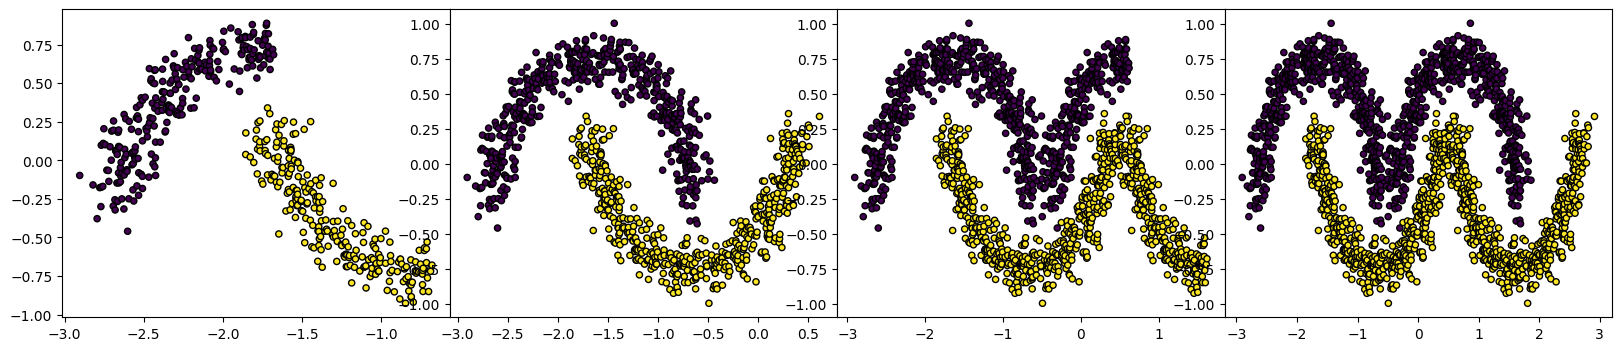

In [6]:
ncols=4
figsiz=(ncols*5,4)

fig,axes = plt.subplots(figsize=figsiz,ncols=ncols)
plt.subplots_adjust(wspace=0, hspace=0)  # No space between columns and rows


for i in range(len(X_all)):    
    
    for j in range(i+1): 
        axes[i].scatter(X_all[j][:, 0].cpu().numpy(), X_all[j][:, 1].cpu().numpy(), c=Y_all[j].cpu().numpy(), edgecolor='k', s=20)
        
        #print(X_all[i].shape)
plt.show()


## batch training 

In [7]:
import os 
dirpath='./results_fourmoon/'
os.makedirs(dirpath,exist_ok=True)

In [8]:
inducing_size_per_task=1
delta=1e-2

ntheta_update=20000+1
num_features=fX_all[0].shape[1]

num_check       = 1
Kprior_joint    = Seq_Kprior(num_features=num_features, num_inducing=inducing_size_per_task, delta=delta).cuda()
modeljoint_path = dirpath + 'check{}_type{}_Kpriorjoint_delta{}.pth.tar'.format(num_check,num_check,delta)



In [9]:

phi_all  = torch.cat(fX_all,dim=0).cuda()
label_all= torch.cat(Y_all,dim=0).cuda()

optimizer_joint_theta = torch.optim.Adam(Kprior_joint.model.parameters(), lr=0.05)    

previous_memory          = None
previous_memory_rescaled = None
previous_memory_scale    = None

    
    

for j in range(ntheta_update):
    optimizer_joint_theta.zero_grad()
    #loss_new , kprior = Kprior.loss_theta(phi_new, label_new, previous_memory)
    loss_new , kprior = Kprior_joint.loss_theta(phi_all, label_all, previous_memory_rescaled, previous_memory_scale)
    
    
    loss = loss_new + kprior
    loss.backward()
    optimizer_joint_theta.step()
    if (j == 0) or (j%1000 == 0):
        print(' step = {}, loss = {:.4f}, loss d = {:.4f}, loss k = {:.4f}'.format( j+1, loss.item(),loss_new.item(),kprior.item() ))



torch.save(Kprior_joint.state_dict(), modeljoint_path),modeljoint_path


 step = 1, loss = 3254.7213, loss d = 3254.7197, loss k = 0.0015
 step = 1001, loss = 65.2520, loss d = 63.9995, loss k = 1.2525
 step = 2001, loss = 33.0051, loss d = 30.3353, loss k = 2.6698
 step = 3001, loss = 23.4075, loss d = 19.4346, loss k = 3.9730
 step = 4001, loss = 19.3473, loss d = 14.2546, loss k = 5.0928
 step = 5001, loss = 17.4367, loss d = 11.4479, loss k = 5.9888
 step = 6001, loss = 16.5291, loss d = 9.8709, loss k = 6.6583
 step = 7001, loss = 16.1286, loss d = 8.9908, loss k = 7.1379
 step = 8001, loss = 15.9902, loss d = 8.5169, loss k = 7.4733
 step = 9001, loss = 15.9627, loss d = 8.2970, loss k = 7.6657
 step = 10001, loss = 15.9607, loss d = 8.2312, loss k = 7.7295
 step = 11001, loss = 15.9607, loss d = 8.2230, loss k = 7.7377
 step = 12001, loss = 15.9607, loss d = 8.2228, loss k = 7.7379
 step = 13001, loss = 15.9607, loss d = 8.2228, loss k = 7.7379
 step = 14001, loss = 15.9607, loss d = 8.2228, loss k = 7.7379
 step = 15001, loss = 15.9607, loss d = 8.2

(None, './results_fourmoon/check1_type1_Kpriorjoint_delta0.01.pth.tar')

## batch trainining results

In [10]:
eps = 0.25
x_min,x_max  = (torch.cat(X_all)[:,0]).min().item() - eps, (torch.cat(X_all)[:,0]).max().item() + eps
y_min,y_max  = (torch.cat(X_all)[:,1]).min().item() - eps, (torch.cat(X_all)[:,1]).max().item() + eps
xx, yy       = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
grid_xy      = np.c_[xx.ravel(), yy.ravel()]



def pred_boundary_test(features_grid, model):
     with torch.no_grad():
         model.eval()
         preds = torch.sigmoid(model(features_grid))
         predicted_classes = (preds >= 0.5) + 0.
     return predicted_classes


features_grid = poly.fit_transform( grid_xy )
features_grid = torch.from_numpy(features_grid)


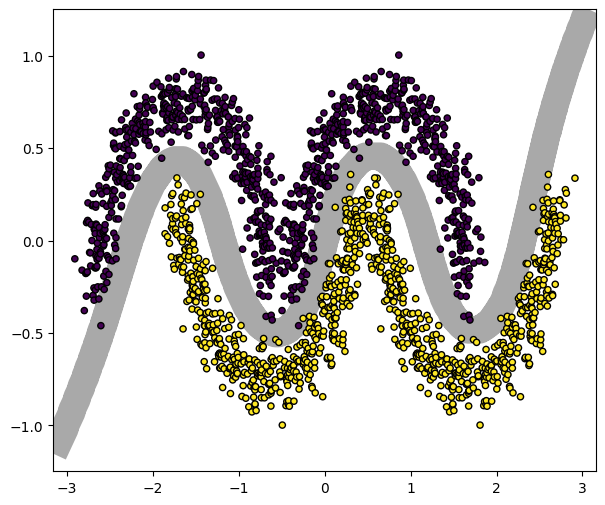

In [11]:


#figsiz=(6.6,5.5)
figsiz=(7,6)

plt.figure(figsize=figsiz)
plt.gca().set_facecolor("white")  # Set background to white
    
   
   
markersiz_data=12   
markersiz_memu=140
#linewidth_db=4.5  
linewidth_db=10

alpha_db=0.75
alpha_dat=0.6   
   
   
fontsiz_db=15
downsample=1

#marker1,marker2='+','^'
marker1,marker2='o','x'
memmarker='o'





## decision joint
color='gray' 
Kprior_joint.load_state_dict(torch.load(modeljoint_path),strict=False)
predicted_classes = pred_boundary_test(features_grid, Kprior_joint.model.cpu())
z                 = predicted_classes.view(xx.shape).numpy()
contour = plt.contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db*3*0.66, colors=[color],alpha=alpha_db*0.9, label='joint db', zorder=0)

for j in range(len(X_all)):
    plt.scatter(X_all[j][:, 0].cpu().numpy(), X_all[j][:, 1].cpu().numpy(), c=Y_all[j].cpu().numpy(), edgecolor='k', s=20)



## proposed method: K-prior with compact memory 

In [12]:
num_features           = fX_all[0].shape[1]

#ntheta_update, nbeta_update,nmem_update,inducing_size_per_task  = 10000,100,1,7  
ntheta_update, nbeta_update,nmem_update,inducing_size_per_task  = 10000,100,1,14  
#ntheta_update, nbeta_update,nmem_update,inducing_size_per_task  = 10000,100,1,21 


Kprior = Seq_Kprior(num_features=num_features, num_inducing=inducing_size_per_task, delta=delta).cuda()





In [13]:
clamp_min=1e-4


phi_new_norm  = torch.tensor([])
phi_new_norm_sum,phi_new_norm_cnt = 0,0

#for i in range(5):
for i in range(len(X_all)):    
    phi_new   = (fX_all[i]).cuda()    
    label_new = (Y_all[i]).cuda()
    
    optimizer_theta = torch.optim.Adam(Kprior.model.parameters(), lr=0.01)    

    if i == 0:
        previous_memory          = None
        previous_memory_rescaled = None
        previous_memory_scale    = None

    else:
        previous_memory_rescaled = updated_memory_rescaled.detach().clone()
        previous_memory_scale    = updated_memory_scale.detach().clone()
        
        

    ## -------- K-prior with cpt memory -------- ##
        
    for j in range(ntheta_update+1):
        optimizer_theta.zero_grad()
        loss_new , kprior = Kprior.loss_theta(phi_new, label_new, previous_memory_rescaled, previous_memory_scale)
        loss              = loss_new + kprior
        
        loss.backward()
        optimizer_theta.step()
        if (j == 0) or (j%1000 == 0):
            print('task no. = {}, step = {}, loss = {:.4f}, loss d = {:.4f}, loss k = {:.4f}'.format(i+1, j+1, loss.item(),loss_new.item(),kprior.item() ))





    ## -------- EM algorithm for PPCA -------- ##

    with torch.no_grad():

        ## compute previous_memory_tild
        if i == 0:
            previous_memory_tilde = []
        else:
            fZ                    = Kprior.model(previous_memory_rescaled)
            predZ                 = torch.sigmoid(fZ)
            beta                  = (predZ* (1- predZ)).clamp(min=clamp_min)
            previous_memory_tilde = previous_memory_rescaled*(previous_memory_scale * beta.pow(0.5) )




        ## compute new phi tilde
        new_feature       = phi_new
        fX                = Kprior.model(new_feature)
        predX             = torch.sigmoid(fX)
        beta              = predX* (1- predX) 
        new_feature_tilde = new_feature * beta.pow(0.5)
        
        


        ## compute init tilde
        new_mem_ini                  = selectet_mem_lambda(Kprior.model, new_feature, inducing_size_per_task)
        phi_new_norm                 =  torch.cat([phi_new_norm , 1*torch.ones(new_mem_ini.size(0),1)],dim=0)
             
        
        if i > 0:
            initialization_rescaled  = torch.cat([ previous_memory_rescaled , new_mem_ini]  ,dim=0)
            initialization_weight    = torch.cat([previous_memory_scale, torch.ones(new_mem_ini.size(0),1).to(previous_memory_scale) ])

        else:
            #initialization  = torch.cat([ new_mem_ini]  ,dim=0)
            initialization_rescaled  = torch.cat([ new_mem_ini]  ,dim=0)
            initialization_weight    = 1

            
        
       
        em_loss_history_min = -1
        for step_j in range(nbeta_update):
            fZ    = Kprior.model(initialization_rescaled)
            predZ = torch.sigmoid(fZ)
            beta  = (predZ* (1- predZ)).clamp(min=clamp_min)


            initialization_tilde  = initialization_rescaled *( initialization_weight * beta.pow(0.5))
            UUT0                  = new_feature_tilde.T    @ new_feature_tilde
            initinitT0            = initialization_tilde.T @ initialization_tilde            
            
                 
                
            initialization_tilde   = learning_memory2(new_feature_tilde, previous_memory_tilde, initialization_tilde, task_id=i, sigma=1e-4)       ## best



            initialization         = initialization_tilde / beta.pow(0.5)            
            initialization_weight  = (initialization.norm(dim=-1,keepdim=True)/phi_new_norm.to(initialization.device))  #(dim,1)
            initialization_weight  = torch.where(initialization_weight > 1, initialization_weight, torch.ones_like(initialization_weight) )
            
            
            
            initialization_rescaled = (1/initialization_weight)*initialization
            


            UUT        = new_feature_tilde.T@new_feature_tilde
            initinitT  = initialization_tilde.T@initialization_tilde
            
            print('step {} Before em loss: {:.4f} \t --> \tem loss: {:.4f}'.format(step_j, torch.norm(UUT0-initinitT0), torch.norm(UUT-initinitT)))                    

            if step_j >= 5:
                if torch.norm(UUT-initinitT) > em_loss_history_min:
                    print('break')
                    break
                else:
                    em_loss_history_min = torch.norm(UUT-initinitT)                                        
            else:
                em_loss_history_min = torch.norm(UUT-initinitT)


        updated_memory_rescaled = initialization_rescaled
        updated_memory_scale    = initialization_weight 
        updated_memory          = updated_memory_rescaled*updated_memory_scale





        model_path = dirpath + 'check{}_type{}_Kprior{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update) 
        mem_path   = dirpath + 'check{}_type{}_memrepr_tid{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update)


        #delta, ntheta_update, nbeta_update,nmem_update = 1e-3,5000,10,3 
        torch.save(Kprior.state_dict(), model_path)
        torch.save({'memorable_points': updated_memory_rescaled,'memorable_points_scale': updated_memory_scale}, mem_path)

    
        Kprior.model_old = copy.deepcopy(Kprior.model)


task no. = 1, step = 1, loss = 421.1235, loss d = 421.1214, loss k = 0.0021
task no. = 1, step = 1001, loss = 1.0148, loss d = 0.9372, loss k = 0.0777
task no. = 1, step = 2001, loss = 0.4749, loss d = 0.3618, loss k = 0.1132
task no. = 1, step = 3001, loss = 0.3342, loss d = 0.1990, loss k = 0.1352
task no. = 1, step = 4001, loss = 0.2778, loss d = 0.1288, loss k = 0.1490
task no. = 1, step = 5001, loss = 0.2510, loss d = 0.0933, loss k = 0.1576
task no. = 1, step = 6001, loss = 0.2367, loss d = 0.0746, loss k = 0.1621
task no. = 1, step = 7001, loss = 0.2290, loss d = 0.0650, loss k = 0.1640
task no. = 1, step = 8001, loss = 0.2252, loss d = 0.0601, loss k = 0.1651
task no. = 1, step = 9001, loss = 0.2238, loss d = 0.0578, loss k = 0.1660
task no. = 1, step = 10001, loss = 0.2233, loss d = 0.0567, loss k = 0.1666
beta of chosem mem
tensor([0.0008, 0.0008, 0.0008, 0.0009, 0.0009, 0.0010, 0.0012, 0.0019, 0.0022,
        0.0026, 0.0033, 0.0045, 0.0085, 0.0142], device='cuda:0',
       d

## gradient inverse mapping

In [14]:
Kprior_joint    = Seq_Kprior(num_features=num_features, num_inducing=inducing_size_per_task, delta=delta).cuda()
modeljoint_path = dirpath + 'check{}_type{}_Kpriorjoint_delta{}.pth.tar'.format(num_check, num_check,delta)
Kprior_joint.load_state_dict(torch.load(modeljoint_path),strict=False)
 

<All keys matched successfully>

In [15]:


gradinverse_points = { 0 : [], 1 : [], 2 : [], 3 : [] } 


for i in range(len(X_all)):



    model_path = dirpath + 'check{}_type{}_Kprior{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update) 
    mem_path   = dirpath + 'check{}_type{}_memrepr_tid{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update)
    

    Kprior.load_state_dict(torch.load(model_path),strict=False)
    Kprior = Kprior.cuda()
    Kprior.eval()
    

    loaded_dict       = torch.load(mem_path )    
    mem   = loaded_dict['memorable_points'].detach().cpu().numpy()
    memsc = loaded_dict['memorable_points_scale'].detach().cpu().numpy()

    ## grad on grid space 
    pred_grid       = Kprior.model(features_grid.cuda()).sigmoid().cpu()
    truelabel_grid  = (pred_grid > 0.5) + 0.    
    grad_grid       = (pred_grid - truelabel_grid)*features_grid


    ## grad on mem 
    mem = torch.from_numpy(mem)
    pred_mem = Kprior.model(mem.cuda() ).sigmoid().cpu()

    pred_mem_true = Kprior_joint.model( mem.cuda() ).sigmoid().cpu() 
    label_mem     = (pred_mem_true > 0.5) + 0.
    mem_grid      = (pred_mem - label_mem)*mem    
    

    for j in range(mem.shape[0]):
        M = torch.tensor(mem_grid[j])


        dists = torch.linalg.norm(grad_grid - M, dim=1, ord=2)


        closest_index = torch.argmin(dists) 
        dist = float(dists[closest_index].cpu())
        print(f'{j+1}, {dist:.10f}')


#        if dist < 0.005:            
        gradinverse_points[i].append(features_grid[closest_index][1:3].cpu().numpy())

    gradinverse_points[i] = np.array(gradinverse_points[i])
    print()
    

    

1, 0.0068429499
2, 0.0079303059
3, 0.0065335844
4, 0.0086408908
5, 0.0064900538
6, 0.0132947511
7, 0.0058260517
8, 0.0155070473
9, 0.0149253277
10, 0.0157161213
11, 0.0093305513
12, 0.0122003152
13, 0.0123378091
14, 0.0130098986

1, 0.0039099254
2, 0.0191710508
3, 0.0030775653
4, 0.0020954336
5, 0.0031809128
6, 0.0336832079
7, 0.0066451667
8, 0.0245299204
9, 0.0214777356
10, 0.0201510776
11, 0.0064662271
12, 0.0041435279
13, 0.0154446801
14, 0.0079241630
15, 0.0018365828
16, 0.0032399832
17, 0.0000044592
18, 0.0000478232
19, 0.0029194246
20, 0.0029849787
21, 0.0000532670
22, 0.0063119313
23, 0.0001381752
24, 0.0041672936
25, 0.0053965773
26, 0.0044926411
27, 0.0078186653
28, 0.0109557690

1, 0.0006373119
2, 0.0308320943
3, 0.0007673761
4, 0.0004762758
5, 0.0008785027
6, 0.0271457323
7, 0.0018961887
8, 0.0223833537
9, 0.0206414555
10, 0.0184823119
11, 0.0063644628
12, 0.0069279227
13, 0.0179509287
14, 0.0129652914
15, 0.0002402686
16, 0.0025431653
17, 0.0000051401
18, 0.0000500044
19, 0

## results of K-prior with compact memory

In [16]:
Kprior       = Seq_Kprior(num_features=num_features, num_inducing=inducing_size_per_task, delta=delta)
Kprior_joint = Seq_Kprior(num_features=num_features, num_inducing=inducing_size_per_task, delta=delta)


## decision boundary progress with memory shown by gradient inverse-mapping

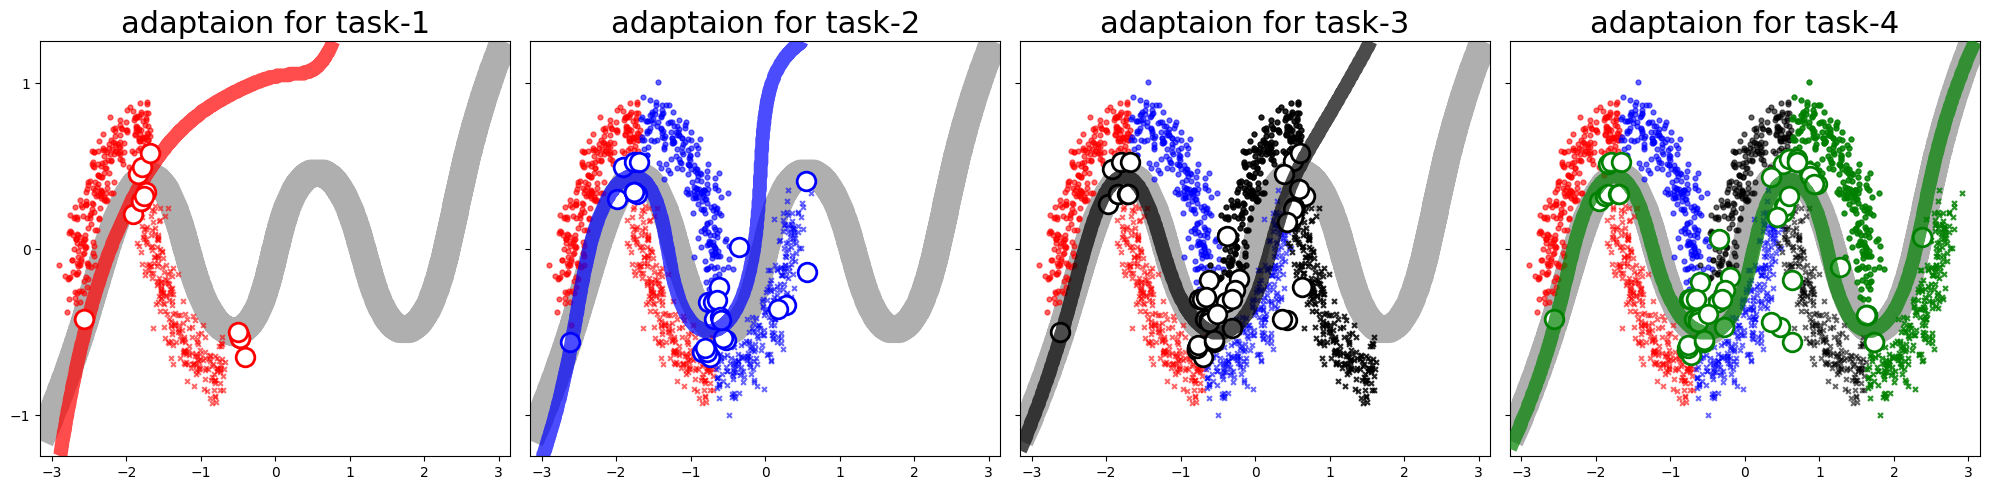

In [17]:



figsiz=(20,5)
   
markersiz_data=12   
markersiz_memu=180
linewidth_db=10

alpha_db=0.7
alpha_dat=0.6   
   
   
fontsiz_db=15
downsample=1

marker1,marker2='o','x'
memmarker='o'





# ###------------------------------------------------------------------###
# ## gradient similarity in feature space 
# ###------------------------------------------------------------------###



#fig= plt.figure(figsize=figsiz)
fig, axes = plt.subplots(ncols=4,figsize=figsiz,sharey=True)  # Creates a figure and a single axes
plt.gca().set_facecolor("white")  # Set background to white
plt.subplots_adjust(wspace=0, hspace=0)  # No space between columns and rows




##--------------------------------------------------------------------------------------------------------------------
## decision joint
color='gray' 

fig_idx = 0

Kprior_joint.load_state_dict(torch.load(dirpath + 'check{}_type{}_Kpriorjoint_delta{}.pth.tar'.format(num_check,num_check,delta)), strict=False)
predicted_classes = pred_boundary_test(features_grid,Kprior_joint.model)
z                 = predicted_classes.view(xx.shape).numpy()

# Plotting
contour = axes[fig_idx].contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db*3*0.66, colors=[color],alpha=alpha_db*0.9, label='joint db', zorder=0)





## decision boundary 1
color='red' 
i=0


model_path = dirpath + 'check{}_type{}_Kprior{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update) 
mem_path   = dirpath + 'check{}_type{}_memrepr_tid{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update)



Kprior.load_state_dict(torch.load(model_path), strict=False)
predicted_classes = pred_boundary_test(features_grid, Kprior.model)
z                 = predicted_classes.view(xx.shape).numpy()

# Plotting
contour= axes[fig_idx].contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db, colors=[color],alpha=alpha_db, zorder=1)


#for j in range(i+1):
idx0 = Y_all[i].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')


# ## memory 
loaded_dict       = torch.load(mem_path)    
mem  = loaded_dict['memorable_points'].detach().cpu().numpy()
axes[fig_idx].scatter(gradinverse_points[i][:, 0], gradinverse_points[i][:, 1],facecolor='white', edgecolors=color, s=markersiz_memu, marker=memmarker, linewidth=2)






##--------------------------------------------------------------------------------------------------------------------

fig_idx=1

color='gray' 
Kprior_joint.load_state_dict(torch.load(dirpath + 'check{}_type{}_Kpriorjoint_delta{}.pth.tar'.format(num_check,num_check,delta)), strict=False)
predicted_classes = pred_boundary_test(features_grid,Kprior_joint.model)
z                 = predicted_classes.view(xx.shape).numpy()

# Plotting
contour = axes[fig_idx].contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db*3*0.66, colors=[color],alpha=alpha_db*0.9, label='joint db', zorder=0)




## decision boundary 1
color='red' 
i=0
idx0 = Y_all[i].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')



i=1 
color='blue'
model_path = dirpath + 'check{}_type{}_Kprior{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update) 
mem_path   = dirpath + 'check{}_type{}_memrepr_tid{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update)

Kprior.load_state_dict(torch.load(model_path), strict=False)
predicted_classes = pred_boundary_test(features_grid, Kprior.model)
z                 = predicted_classes.view(xx.shape).numpy()


# Plotting
contour=axes[fig_idx].contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db, colors=[color],alpha=alpha_db, label='task2 db', zorder=2)

idx0 = Y_all[fig_idx].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')



## memory 
loaded_dict       = torch.load(mem_path)    
mem  = loaded_dict['memorable_points'].detach().cpu().numpy()
axes[fig_idx].scatter(gradinverse_points[i][:, 0], gradinverse_points[i][:, 1],facecolor='white', edgecolors=color, s=markersiz_memu, marker=memmarker, linewidth=2)






##--------------------------------------------------------------------------------------------------------------------
## decision boundary 3

fig_idx=2

color='gray' 
Kprior_joint.load_state_dict(torch.load(dirpath + 'check{}_type{}_Kpriorjoint_delta{}.pth.tar'.format(num_check,num_check,delta)), strict=False)
predicted_classes = pred_boundary_test(features_grid,Kprior_joint.model)
z                 = predicted_classes.view(xx.shape).numpy()

contour = axes[fig_idx].contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db*3*0.66, colors=[color],alpha=alpha_db*0.9, label='joint db', zorder=0)




color='red' 
i=0
idx0 = Y_all[i].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')


color='blue'
i=1 
idx0 = Y_all[fig_idx].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')


color='black'
i=2
idx0 = Y_all[fig_idx].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')






model_path = dirpath + 'check{}_type{}_Kprior{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update) 
mem_path   = dirpath + 'check{}_type{}_memrepr_tid{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update)

Kprior.load_state_dict(torch.load(model_path), strict=False)
predicted_classes = pred_boundary_test(features_grid, Kprior.model)
z                 = predicted_classes.view(xx.shape).numpy()


# Plotting
contour = axes[fig_idx].contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db, colors=[color],alpha=alpha_db, label='task3 db', zorder=3)


#for j in range(i+1):
idx0 = Y_all[i].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')




## memory 
loaded_dict       = torch.load(mem_path)    
mem               = loaded_dict['memorable_points'].detach().cpu().numpy()
axes[fig_idx].scatter(gradinverse_points[i][:, 0], gradinverse_points[i][:, 1],facecolor='white', edgecolors=color, s=markersiz_memu, marker=memmarker, linewidth=2)











##--------------------------------------------------------------------------------------------------------------------

## decision boundary 4 
color='green'


fig_idx=3

color='gray' 
Kprior_joint.load_state_dict(torch.load(dirpath + 'check{}_type{}_Kpriorjoint_delta{}.pth.tar'.format(num_check,num_check,delta)), strict=False)
predicted_classes = pred_boundary_test(features_grid,Kprior_joint.model)
z                 = predicted_classes.view(xx.shape).numpy()

contour = axes[fig_idx].contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db*3*0.66, colors=[color],alpha=alpha_db*0.9, label='joint db', zorder=0)




color='red' 
i=0
idx0 = Y_all[i].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')


color='blue'
i=1 
idx0 = Y_all[fig_idx].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')


color='black'
i=2
idx0 = Y_all[fig_idx].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')




color='green'
i=3
idx0 = Y_all[fig_idx].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')




model_path = dirpath + 'check{}_type{}_Kprior{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update) 
mem_path   = dirpath + 'check{}_type{}_memrepr_tid{}_delta{}_npu{}_nbu{}_nmu{}.pth.tar'.format(num_check,num_check,i, delta,ntheta_update, nbeta_update,nmem_update)

Kprior.load_state_dict(torch.load(model_path), strict=False)
predicted_classes = pred_boundary_test(features_grid, Kprior.model)
z                 = predicted_classes.view(xx.shape).numpy()


# Plotting
contour = axes[fig_idx].contour(xx, yy, z ,levels=[0.5], linewidths=linewidth_db, colors=[color],alpha=alpha_db, label='task3 db', zorder=3)


#for j in range(i+1):
idx0 = Y_all[i].cpu().numpy() == 0
idx = np.where(idx0)[0]
idxnot = np.where(~idx0)[0]

axes[fig_idx].scatter(X_all[i][idx[::downsample], 0].cpu().numpy(), X_all[i][idx[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data ,marker=marker1, label='0 in task 3')
axes[fig_idx].scatter(X_all[i][idxnot[::downsample], 0].cpu().numpy(), X_all[i][idxnot[::downsample], 1].cpu().numpy(), alpha=alpha_dat, color=color, s=markersiz_data,marker=marker2, label='1 in task 3')




## memory 
loaded_dict       = torch.load(mem_path)    
mem               = loaded_dict['memorable_points'].detach().cpu().numpy()
axes[fig_idx].scatter(gradinverse_points[i][:, 0], gradinverse_points[i][:, 1],facecolor='white', edgecolors=color, s=markersiz_memu, marker=memmarker, linewidth=2)




axes[0].set_yticks([-1,0,1])


for i in range(1,4+1):
    axes[i-1].set_title('adaptaion for task-{}'.format(i),fontsize=22)



#plt.title('gradient-similarity used for learned mem',fontsize=15)
plt.tight_layout()
plt.savefig('fourmoons_db_mem_grad_full_memsize{}.pdf'.format(inducing_size_per_task), dpi=300, format='pdf', bbox_inches='tight')



plt.show()








